# LDA (Latent Dirichlet Allocation) & LSI (Latent Semantic Indexing)

#### Set parameters for how final model results will be saved

In [139]:
tokenized_run_name = "unweighted_nowiki_1_tokens"  #manually input the filename (no extension) to be used as input

In [140]:
data_directory = "../data/"
output_directory = "../outputs/"

In [141]:
base_model_type = "lda_lsi"
model_name_suffix = ""  #default should be blank; use to make note of any other mods
run_number = 1

In [142]:
final_model_name = f"{base_model_type}_{tokenized_run_name[:-7]}_run{run_number}{model_name_suffix}"

#### Imports

In [143]:
# general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # for LDA modeling & presentation
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# # for LSA modeling
from sklearn.decomposition import TruncatedSVD

# for progress bar on loops
from tqdm import tqdm

#### Read in Dataframe with tokenized text

In [144]:
df = pd.read_csv(f"{data_directory}{tokenized_run_name}.csv")
df.head()

,name,href,tokenized_text
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...


In [145]:
df.isna().sum()

name              0
href              0
tokenized_text    0
dtype: int64

In [146]:
df.fillna("",inplace=True)

#### Count Vectorization & TfIDF

In [147]:
# Function draws heavily from Jiamei Wang's code: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def make_tfidf(input_df, text_colname='tokenized_text'):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        
    OUTPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    docs_raw = input_df[text_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    cvec = CountVectorizer(strip_accents = 'unicode',
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                            max_df = 0.5,                        # discard words that appear in > 50% of the reviews
                            min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**cvec.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} non-unique words in {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], text_colname, dtm_tfidf.shape[1]))
    
    # return tf_vectorizer, tfidf_vectorizer, dtm_tfidf
    return tfidf_vectorizer, dtm_tfidf

In [148]:
tfidf_vectorizer, dtm_tfidf = make_tfidf(df, 'tokenized_text')

The shape of the tfidf is (2484, 1783), meaning that there are 2484 non-unique words in tokenized_text and 1783 tokens made through the filtering process.


d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


#### Grid Search for best LDA model

In [149]:
# Define Grid Search Parameters
search_params = {'n_components': [5, 10, 20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

In [150]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_gridsearch(dtm_tfidf, search_params):
    '''
    INPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        model_gs - the GridSearchCV object
        best_lda_model - the best model, as determined by the grid search
    '''

    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model_gs = GridSearchCV(lda, param_grid=search_params, n_jobs=8, verbose=3)

    # Do the Grid Search
    model_gs.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model_gs.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model_gs.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model_gs.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    return model_gs, best_lda_model

In [151]:
model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Model Log Likelihood Score:  -22904.156645148112
Model Perplexity:  3378.4541795692253


#### Plotting LDA model performance

In [152]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_plot_performance(model_gs, search_params):
    ''' 
    INPUTS:
        model_gs - the GridSearchCV object
        
    OUTPUTS:
        A graph comparing LDA Model Performance Scores with different params
    '''

    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelihoods from Grid Search Output
    gscore=model_gs.cv_results_

    log_likelihoods = {}
    for i in search_params['learning_decay']:
        log_likelihoods[i] = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==i]

    # Show graph
    plt.figure(figsize=(12, 8))
    for i in log_likelihoods:
        plt.plot(search_params['n_components'], log_likelihoods[i], label=i)
 
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return

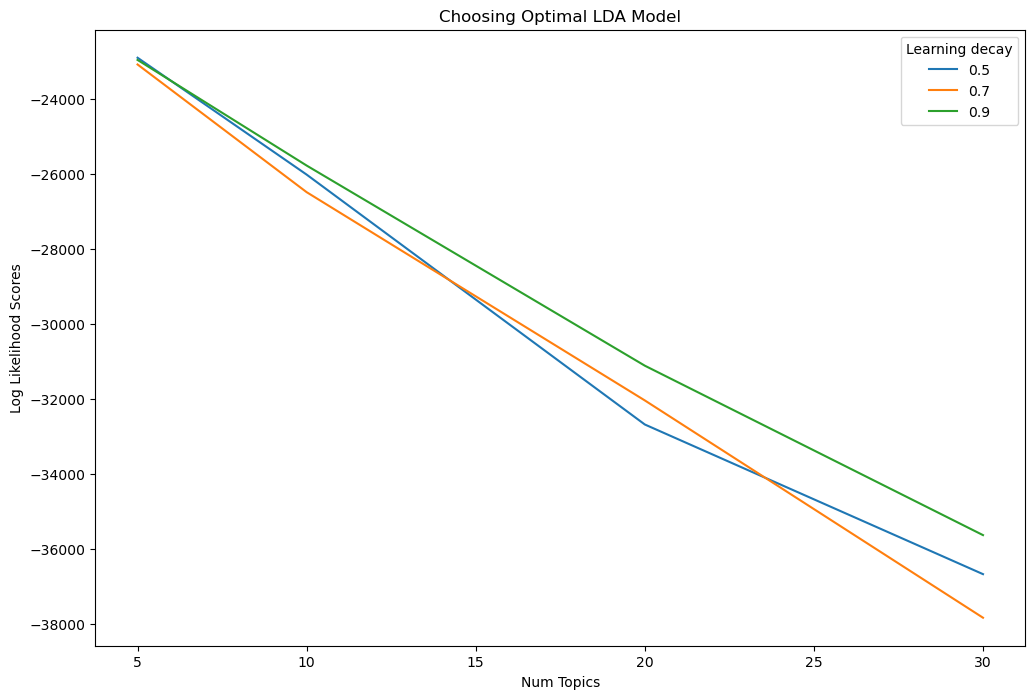

In [153]:
lda_plot_performance(model_gs, search_params)

#### (optional) Combined function for creating "best" LDA model with performance plot

In [154]:
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for more convenient parameter tuning)
# Once tuned/optimized, all 3 sub-functions can be run together in one command, wholly recreating the method used in the source referenced above

def optimal_lda_model(input_df, text_colname, search_params):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        best_lda_model - the best model, as determined by the grid search
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    
    tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
    model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)
    lda_plot_performance(model_gs, search_params)

    return best_lda_model, dtm_tfidf, tfidf_vectorizer

In [155]:
# (Same as above, in one single function call)

# best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df, 'combined_text', search_params)

#### Display topic keywords & weights

In [156]:
# Function excerpted directly with no additional modifications from: (Jiamei Wang)
# https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in tqdm(enumerate(model.components_)):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [157]:
lda_topic_words = display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words.head(10)

5it [00:00, 4995.60it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,comedy,31.4,spy,7.0,school,51.0,adventure,42.5,crime,56.2
1,series,25.3,vampire,6.3,high,26.8,world,41.1,police,37.3
2,television,20.3,terrorist,6.0,comedy,23.3,action,34.3,detective,37.0
3,family,19.7,cia,4.7,life,23.2,war,32.3,murder,35.1
4,music,15.6,fashion,4.6,family,22.2,base,28.5,mystery,25.1
5,reality,14.0,tokyo,4.4,romance,20.3,family,26.4,investigation,24.9
6,american,13.8,demon,4.4,friend,18.7,alien,26.4,criminal,19.7
7,new,13.3,ben,4.2,girl,17.8,life,25.3,killer,19.2
8,sitcom,13.1,hometown,4.0,student,17.7,story,24.8,new,16.4
9,talk,12.8,supernatural,3.9,love,16.5,history,24.3,case,15.7


#### Visualizing LDA output with the pyLDAvis library

In [158]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.035983 -0.037538       1        1  37.659323
4     -0.103960  0.049875       2        1  21.372991
2      0.031446 -0.125259       3        1  18.418268
0      0.145821  0.065456       4        1  17.256567
1     -0.037324  0.047467       5        1   5.292851, topic_info=            Term       Freq      Total Category  logprob  loglift
1376      school  45.000000  45.000000  Default  30.0000  30.0000
377        crime  56.000000  56.000000  Default  29.0000  29.0000
446    detective  32.000000  32.000000  Default  28.0000  28.0000
1184      police  33.000000  33.000000  Default  27.0000  27.0000
1037      murder  35.000000  35.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
604          fbi   2.775503  12.868899   Topic5  -5.3895   1.4048
673         game   2.568045  18.962819   Topic5  -5.4672   0.9395
1600    thriller   2.399709  22.101680   Topic5  -5.5350   0.7185
336   conspiracy   2.246127  12.653575   Topic5  -5.6011   1.2101
770       horror   2.283751  24.934456   Topic5  -5.5845   0.5484

[304 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         3  0.641698  academy
8         4  0.213899  academy
15        1  0.711894   action
15        2  0.166108   action
15        3  0.071189   action
...     ...       ...      ...
1780      1  0.435213    young
1780      2  0.190406    young
1780      3  0.272008    young
1780      4  0.081602    young
1780      5  0.027201    young

[585 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

#### Generate results (fit-transorm) from a LDA model and tfidf matrix

In [159]:
lda_results = best_lda_model.fit_transform(dtm_tfidf) 

#### Append the LDA topic % matches onto the results dataframe

In [160]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lda_topic_pct_cols(lda_results, df_to_append_to, name_prefix=""):
    
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lda_results[j]):
            df_to_append_to.loc[j, f"{name_prefix}lda_topic{i}_match_pct"] = topic
    return
        

In [161]:
make_lda_topic_pct_cols(lda_results, df)

100%|██████████| 2484/2484 [00:00<00:00, 3903.35it/s]


In [162]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.277926,0.030600,0.031683,0.628869,0.030922
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.038942,0.038328,0.844778,0.039261,0.038691
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.229123,0.031837,0.032770,0.674075,0.032194
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.039869,0.039444,0.840869,0.040303,0.039514
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.040637,0.039695,0.040180,0.839726,0.039762


In [163]:
df.shape

(2484, 8)

# LSA model

In [164]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/


# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_results = lsa.fit_transform(dtm_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [165]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

# Print the topics with their terms

def lsa_topics_out(tfidf_vectorizer, svd_object):
    terms = tfidf_vectorizer.get_feature_names_out()

    for index, component in enumerate(svd_object.components_):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

    return

In [166]:
lsa_topics_out(tfidf_vectorizer, lsa)

Topic 0:  ['family', 'life', 'comedy', 'new', 'school', 'crime', 'world', 'adventure', 'series', 'base']
Topic 1:  ['crime', 'detective', 'police', 'murder', 'investigation', 'mystery', 'killer', 'serial', 'criminal', 'case']
Topic 2:  ['school', 'family', 'high', 'comedy', 'romance', 'life', 'love', 'sitcom', 'york', 'student']
Topic 3:  ['school', 'high', 'student', 'girl', 'anime', 'teen', 'detective', 'action', 'manga', 'teenage']
Topic 4:  ['new', 'york', 'city', 'space', 'superhero', 'police', 'alien', 'adventure', 'comedy', 'team']
Topic 5:  ['family', 'alien', 'space', 'detective', 'earth', 'planet', 'dysfunctional', 'murder', 'child', 'mystery']
Topic 6:  ['war', 'new', 'york', 'love', 'history', 'city', 'romance', 'century', 'historical', 'woman']
Topic 7:  ['space', 'alien', 'school', 'documentary', 'high', 'planet', 'earth', 'history', 'crew', 'mission']
Topic 8:  ['horror', 'anthology', 'alien', 'town', 'space', 'small', 'new', 'supernatural', 'mystery', 'fantasy']
Topic 9

In [167]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lsa_topic_pct_cols(lsa_results, df_to_append_to):
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lsa_results[j]):
            df_to_append_to.loc[j, f"lsa_topic{i}_cos_match"] = topic
    return

In [168]:
make_lsa_topic_pct_cols(lsa_results, df)

100%|██████████| 2484/2484 [00:01<00:00, 2171.22it/s]


In [169]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct,lsa_topic0_cos_match,lsa_topic1_cos_match,lsa_topic2_cos_match,lsa_topic3_cos_match,lsa_topic4_cos_match,lsa_topic5_cos_match,lsa_topic6_cos_match,lsa_topic7_cos_match,lsa_topic8_cos_match,lsa_topic9_cos_match
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.277926,0.030600,0.031683,0.628869,0.030922,0.218552,-0.054513,-0.170666,-0.050945,-0.112026,0.060865,0.061312,-0.111452,-0.078752,-0.087379
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.038942,0.038328,0.844778,0.039261,0.038691,0.131392,0.030904,-0.031671,0.004202,-0.002732,0.051975,0.009105,0.010824,-0.024610,0.027175
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.229123,0.031837,0.032770,0.674075,0.032194,0.175254,-0.058711,-0.162202,-0.050734,-0.089087,0.017601,0.050662,-0.022926,-0.128331,-0.080628
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.039869,0.039444,0.840869,0.040303,0.039514,0.139793,0.010130,-0.063136,0.039768,0.028712,-0.017671,-0.038942,-0.064338,-0.068518,-0.010091
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.040637,0.039695,0.040180,0.839726,0.039762,0.096911,-0.038721,-0.152185,0.009575,0.087342,0.048612,0.016643,0.139472,0.075890,0.015352


In [170]:
df.shape

(2484, 18)

## Force LDA evaluate with different parameters

#### Generate same output items for forced alternate (20+ topic) model

In [171]:
# Define Grid Search Parameters
search_params2 = {'n_components': [20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 20}
Model Log Likelihood Score:  -30978.8328898263
Model Perplexity:  15644.376425119031


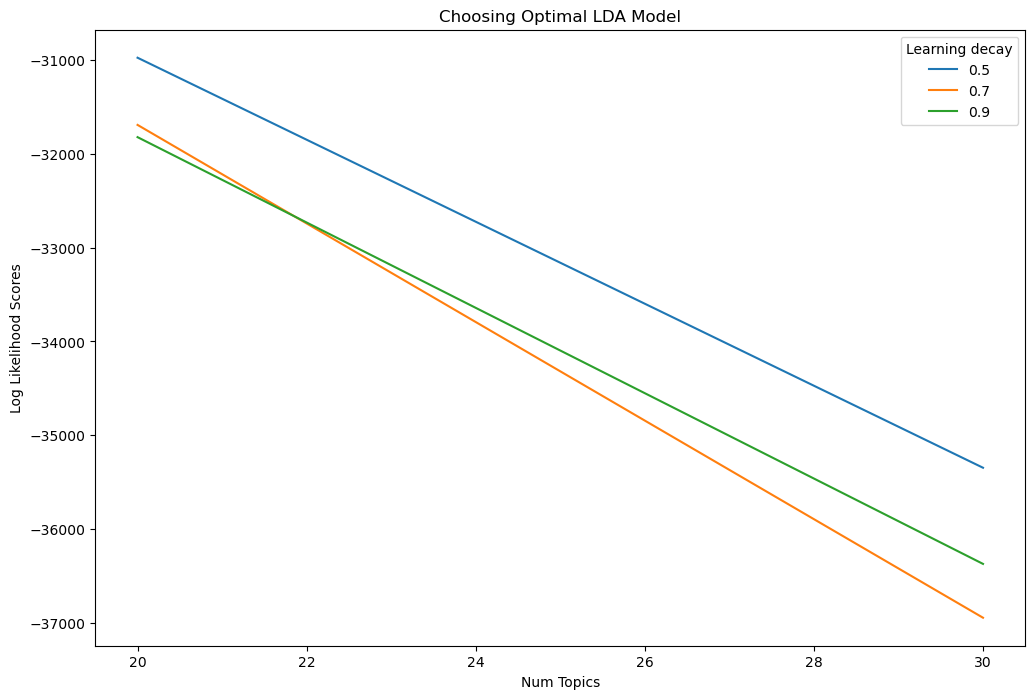

In [172]:
# tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
model_gs2, best_lda_model2 = lda_gridsearch(dtm_tfidf, search_params2)
lda_plot_performance(model_gs2, search_params2)

In [173]:
lda_topic_words2 = display_topics(best_lda_model2, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words2.head()

20it [00:00, 6639.18it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,...,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights,Topic 20 words,Topic 20 weights
0,competition,10.9,night,6.7,world,39.0,sketch,6.1,crime,12.9,...,treasure,3.0,family,5.6,talk,7.3,town,13.1,witch,3.9
1,reality,6.0,late,6.3,adventure,35.6,music,3.0,space,10.2,...,link,2.5,chicago,4.6,comedy,6.9,new,11.3,adventurer,2.7
2,compete,5.6,music,4.6,life,27.2,coast,2.9,agent,9.0,...,rebellion,1.5,park,4.1,guest,5.3,hospital,11.0,hip,2.7
3,win,4.1,jimmy,4.1,action,26.3,audience,2.7,story,7.7,...,revival,1.4,class,3.5,host,5.3,life,9.9,grant,2.7
4,game,4.0,talk,3.7,alien,25.7,topic,2.4,fbi,7.7,...,journey,1.3,upper,3.3,comedian,5.2,small,9.6,wish,2.5


In [174]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model2, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.138834  0.058760       1        1  31.714457
14     0.198456 -0.031778       2        1  16.948680
18     0.136364 -0.036039       3        1   9.685457
4      0.069725  0.188456       4        1   5.864130
6      0.021980  0.027856       5        1   4.680381
10     0.088909 -0.153666       6        1   4.375064
8      0.042063  0.107212       7        1   3.410022
17    -0.064936 -0.079484       8        1   2.881352
11    -0.068228  0.058607       9        1   2.785086
13     0.056681 -0.071453      10        1   2.645618
1     -0.073611 -0.051620      11        1   2.131934
16    -0.007379 -0.098246      12        1   1.862704
12    -0.051327  0.082497      13        1   1.756874
0     -0.094705 -0.016612      14        1   1.648107
5     -0.095845 -0.005913      15        1   1.528708
3     -0.099136 -0.004704      16        1   1.515049
19    -0.064319  0.018181      17        1   1.358383
15    -0.048898  0.007581      18        1   1.078249
9     -0.041128  0.004188      19        1   1.068503
7     -0.043498 -0.003823      20        1   1.061242, topic_info=          Term       Freq      Total Category  logprob  loglift
377      crime  56.000000  56.000000  Default  30.0000  30.0000
593     family  69.000000  69.000000  Default  29.0000  29.0000
311     comedy  64.000000  64.000000  Default  28.0000  28.0000
1407    series  48.000000  48.000000  Default  27.0000  27.0000
1376    school  44.000000  44.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
212   business   0.741734  11.106917  Topic20  -5.1022   1.8394
118   audience   0.405865   4.892401  Topic20  -5.7052   2.0563
575     expose   0.412339   5.278485  Topic20  -5.6894   1.9962
660     friend   0.651868  31.064727  Topic20  -5.2314   0.6817
1531   summary   0.409891   6.618350  Topic20  -5.6953   1.7640

[935 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         2  0.321122  abilities
2        10  0.321122  abilities
5         4  0.657469     aboard
6         6  0.367051     abroad
6         7  0.367051     abroad
...     ...       ...        ...
1780      5  0.027360      young
1780      6  0.054719      young
1780     10  0.054719      young
1782     10  0.334179     zombie
1782     11  0.501268     zombie

[1930 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 15, 19, 5, 7, 11, 9, 18, 12, 14, 2, 17, 13, 1, 6, 4, 20, 16, 10, 8])

In [175]:
lda_results2 = best_lda_model2.fit_transform(dtm_tfidf) 

In [176]:
make_lda_topic_pct_cols(lda_results2, df, "forced_alt_")

100%|██████████| 2484/2484 [00:03<00:00, 712.35it/s]


## Save final results dataframe

> Saves only the results columns.  All other columns can be obtained from prior dataframes

In [177]:
df.columns

Index(['name', 'href', 'tokenized_text', 'lda_topic0_match_pct',
       'lda_topic1_match_pct', 'lda_topic2_match_pct', 'lda_topic3_match_pct',
       'lda_topic4_match_pct', 'lsa_topic0_cos_match', 'lsa_topic1_cos_match',
       'lsa_topic2_cos_match', 'lsa_topic3_cos_match', 'lsa_topic4_cos_match',
       'lsa_topic5_cos_match', 'lsa_topic6_cos_match', 'lsa_topic7_cos_match',
       'lsa_topic8_cos_match', 'lsa_topic9_cos_match',
       'forced_alt_lda_topic0_match_pct', 'forced_alt_lda_topic1_match_pct',
       'forced_alt_lda_topic2_match_pct', 'forced_alt_lda_topic3_match_pct',
       'forced_alt_lda_topic4_match_pct', 'forced_alt_lda_topic5_match_pct',
       'forced_alt_lda_topic6_match_pct', 'forced_alt_lda_topic7_match_pct',
       'forced_alt_lda_topic8_match_pct', 'forced_alt_lda_topic9_match_pct',
       'forced_alt_lda_topic10_match_pct', 'forced_alt_lda_topic11_match_pct',
       'forced_alt_lda_topic12_match_pct', 'forced_alt_lda_topic13_match_pct',
       'forced_alt_ld

In [178]:
# (default) if reading from a tokenized-only df
columns_to_drop = ['tokenized_text']

# for cases run using other (non-standard) df's as input
#columns_to_drop = ['combined_text', 'lemmatized_text', 'tokenized_text']

In [179]:
df.drop(columns=columns_to_drop, inplace=True)

In [180]:
df.to_csv(f"{output_directory}{final_model_name}.csv", index=False)
# df.to_json(f"{output_directory}{final_model_name}.json")

#### Save topic words matrices

In [181]:
lda_topic_words.to_csv(f"{output_directory}{final_model_name}_topicwords.csv", index=False)

In [182]:
lda_topic_words2.to_csv(f"{output_directory}{final_model_name}_topicwords_forced_alt.csv", index=False)